<h1 style="text-align: center">
Deep Learning HW4 </br>
VAE and CVAE
</h1>


### Full Name: MohammadHosein Ostadi
### Student ID: 99101098

# Import necessary libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision

# Define the MNIST dataset and data loader

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Data Visualization

In [ ]:
# Function to display an image
def show_image(image, figsize=(5, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

# Function to show random images from each class
def show_random_images_from_each_class(dataset, num_images_per_class=4, figsize=(10, 20)):
    class_labels = list(range(10))
    fig, axs = plt.subplots(len(class_labels), num_images_per_class, figsize=figsize)

    for i, label in enumerate(class_labels):
        class_indices = [idx for idx, target in enumerate(dataset.targets) if target == label]
        random_indices = random.sample(class_indices, num_images_per_class)

        for j, idx in enumerate(random_indices):
            image, target = dataset[idx]
            axs[i, j].imshow(image[0], cmap='gray')
            axs[i, j].set_title(f"Class {label}", fontsize=16)
            axs[i, j].axis('off')
            axs[i, j].set_aspect('equal')
            axs[i, j].grid(True)

    plt.tight_layout()
    plt.show()

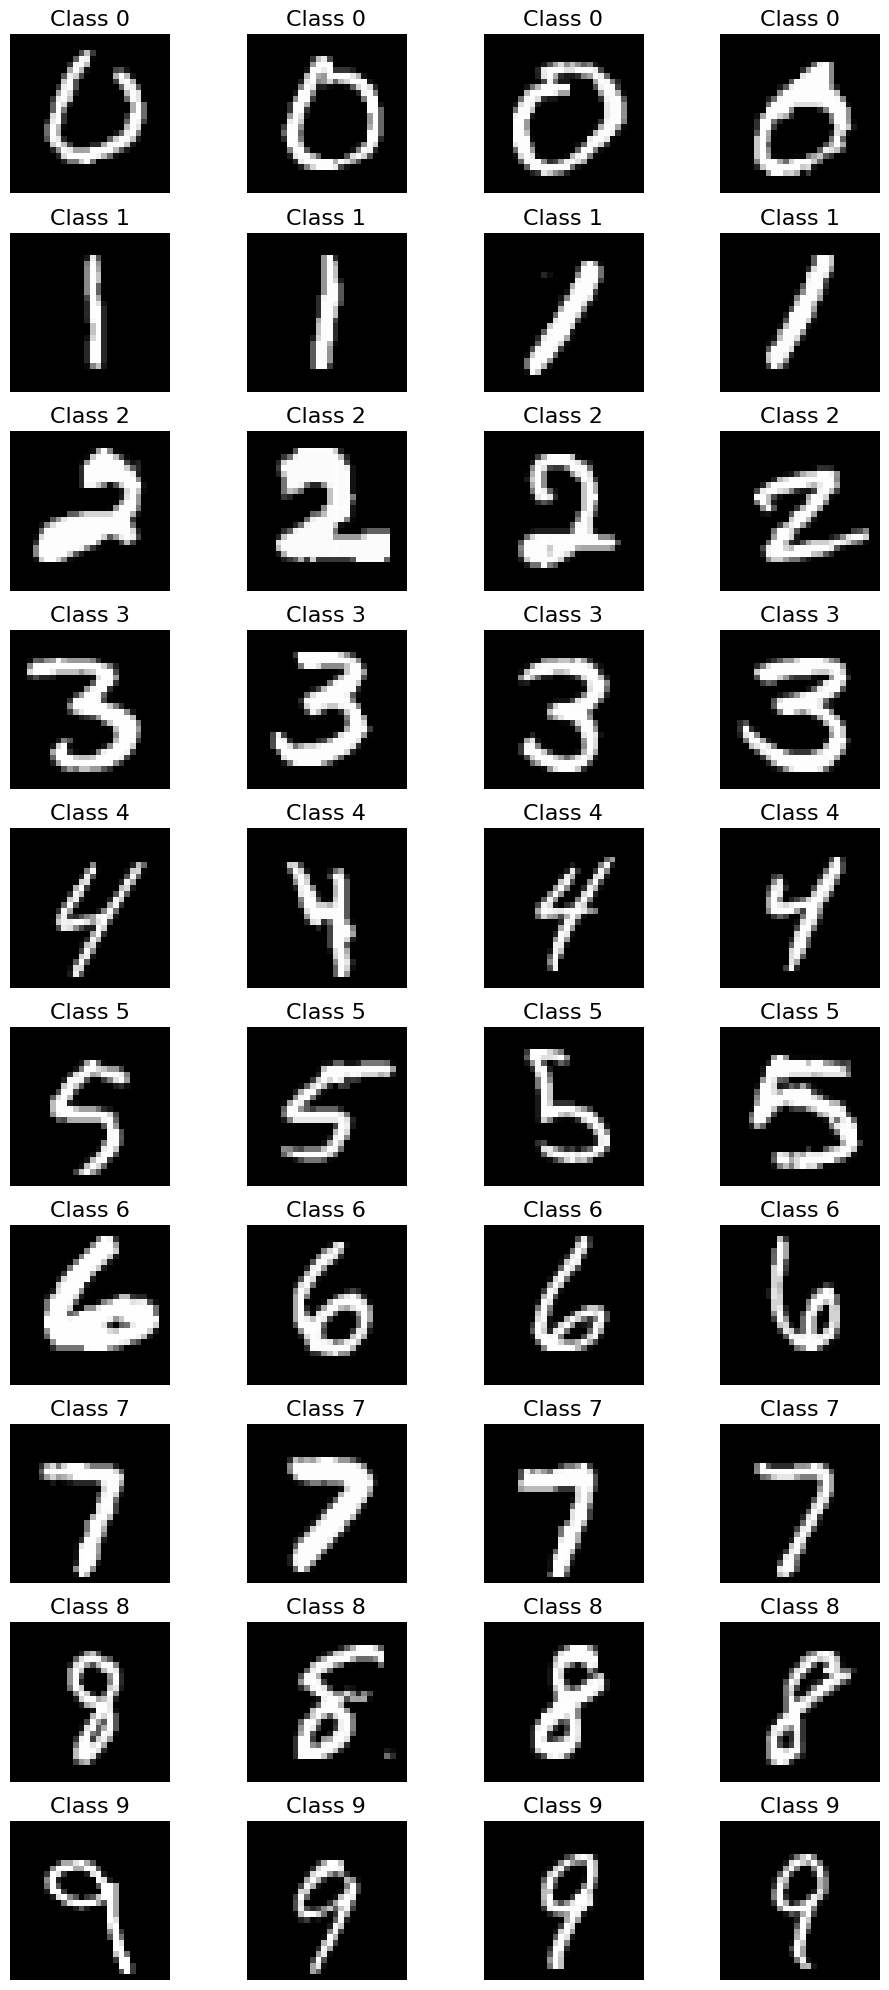

In [ ]:
# Use the function to show random images from each class
show_random_images_from_each_class(train_dataset, num_images_per_class=4)

Exercise: Variational Autoencoders (VAE) and Conditional Variational Autoencoders (CVAE)

with MLP Architectures

In this exercise, we'll explore Variational Autoencoders (VAE) and Conditional VAE (CVAE) using PyTorch.

We will implement these models using Multi-Layer Perceptrons (MLP)

Let's get started!

# 1) VAE --> MLP

we defined the VAE with three layers and leakyReLU as activation function. The network is symmetric. The input_dim is 28*28=784; So the neurons number in each layer have been chosen so that the changes in layers size be smooth.

In [ ]:
# Define a simple VAE class with MLP architecture

class VAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE_MLP, self).__init__()
        # TODO: Define the architecture of the encoder and decoder
        self.encoder = nn.Sequential(
            # TODO: Add layers for the encoder
            nn.Linear(input_dim, 128),
            # nn.ReLU(),
            nn.LeakyReLU(),
            nn.Linear(128, 32),
            # nn.ReLU(),
            nn.LeakyReLU(),
            nn.Linear(32, 8),
            # nn.ReLU(),
            nn.LeakyReLU(),
            # nn.Linear(8, latent_dim * 2)  # Two times latent_dim for mu and logvar
        )
        self.fc_mu = nn.Linear(8,latent_dim)
        self.fc_logvar = nn.Linear(8,latent_dim)
        self.decoder = nn.Sequential(
            # TODO: Add layers for the decoder
            nn.Linear(latent_dim, 8),
            # nn.LReLU(),
            nn.LeakyReLU(),
            nn.Linear(8, 32),
            # nn.ReLU(),
            nn.LeakyReLU(),
            nn.Linear(32, 128),
            # nn.ReLU(),
            nn.LeakyReLU(),
            nn.Linear(128, input_dim),
            nn.Softmax(dim=1)  # Softmax activation for multi-class classification
        )

    def reparameterize(self, mu, logvar):
        # TODO: Implement the reparameterization trick
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z
        # pass

    def forward(self, x):
        # TODO: Implement the forward pass
        # Encoder
        x = self.encoder(x)
        # mu, logvar = torch.chunk(x, 2, dim=1)  # Split into mu and logvar
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        z = self.reparameterize(mu, logvar)
        # Decoder
        x_recon = self.decoder(z)
        return x_recon, mu, logvar

In [ ]:
# Define VAE loss function

def vae_loss(recon, data, mu, logvar):
    # TODO: Implement the reconstruction loss
    reconstruction_loss = F.binary_cross_entropy(recon, data.view(-1, 784), reduction='sum')

    # TODO: Implement the KL divergence loss
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # TODO: Return the total loss as the sum of reconstruction and KL divergence losses
    return kl_divergence + reconstruction_loss

In [ ]:
# Training Loop - VAE (MLP)
def train_vae_mlp(model, train_loader, num_epochs=10, learning_rate=3e-3):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None

    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            # TODO: Forward process
            recon, mu, logvar = model(data.view(-1,28*28))
            # TODO: Flatten the data and recon tensors
            data = data.view(-1, 784)
            recon = recon.view(-1, 784)

            # TODO: Calculate the loss using the vae_loss function
            loss = vae_loss(recon, data, mu, logvar)

            # TODO: Backpropagation and optimization step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader.dataset)
        print(f'VAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        # Show some sample images after each epoch
        if (epoch + 1) % 1 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_samples = 6  # Generate num_samples random samples
                sample = torch.randn(num_samples, 2)
                sample = model.decoder(sample).view(num_samples, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_samples, figsize=(15, 2))
                for i in range(num_samples):
                    axs[i].imshow(sample[i], cmap='gray')
                    axs[i].axis('off')
                plt.show()

        # TODO: Save the best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = model.state_dict()  # TODO: Save the model

    # TODO: Save the best model to a file
    torch.save(best_model, 'best_vae_mlp_model.pth')
    print("Best model saved as 'best_vae_mlp_model.pth'")


Although the loss does not decrease significantly, the reconstructed images are still distinguishable.


##################################################
VAE-MLP Epoch [1/10], Loss: 577.9869130208333
Sample Images:


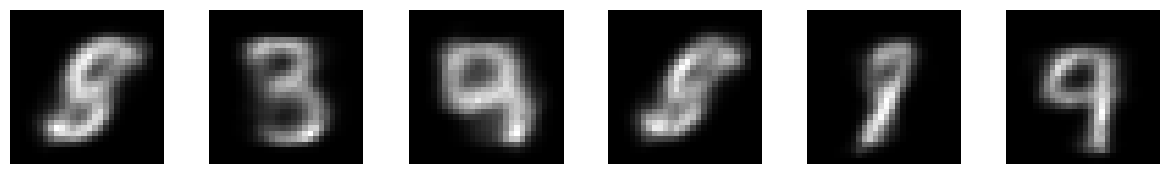


##################################################
VAE-MLP Epoch [2/10], Loss: 566.5687429036458
Sample Images:


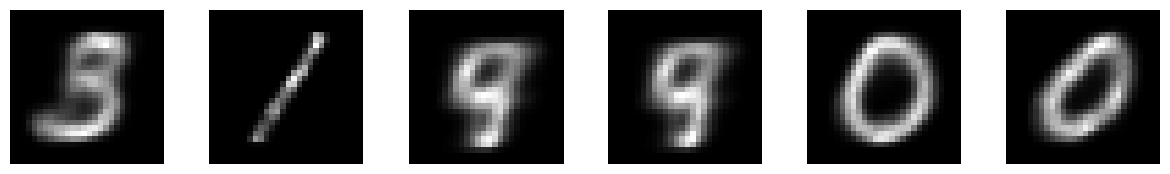


##################################################
VAE-MLP Epoch [3/10], Loss: 564.4183103515625
Sample Images:


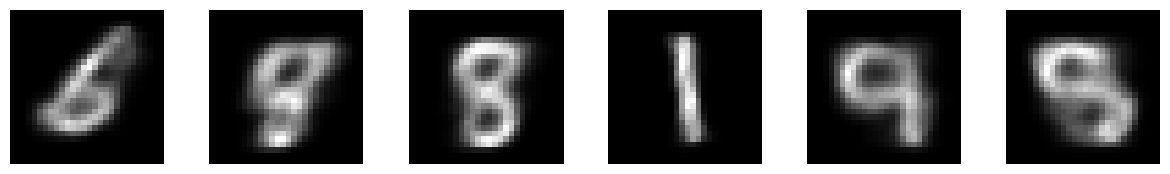


##################################################
VAE-MLP Epoch [4/10], Loss: 563.047093359375
Sample Images:


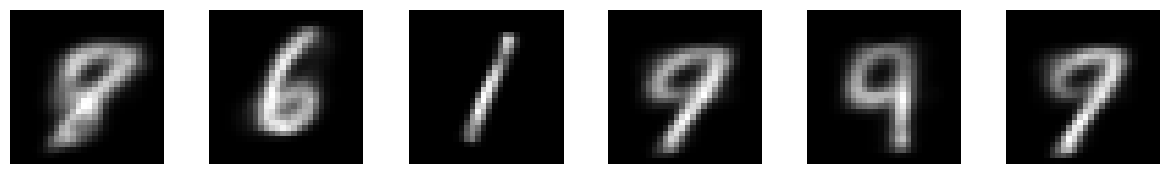


##################################################
VAE-MLP Epoch [5/10], Loss: 562.2720032552083
Sample Images:


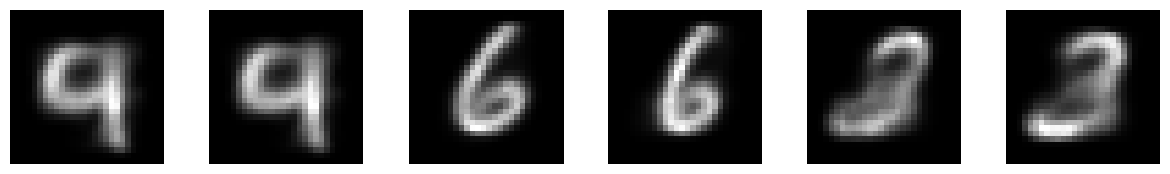


##################################################
VAE-MLP Epoch [6/10], Loss: 561.6539917643229
Sample Images:


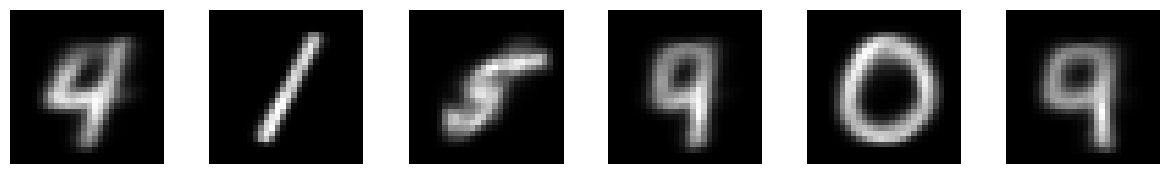


##################################################
VAE-MLP Epoch [7/10], Loss: 561.2529150390625
Sample Images:


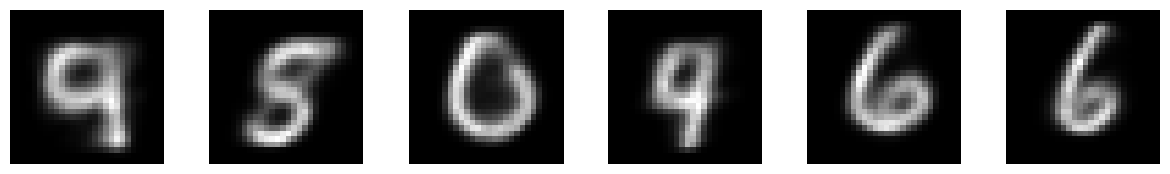


##################################################
VAE-MLP Epoch [8/10], Loss: 560.7852755533854
Sample Images:


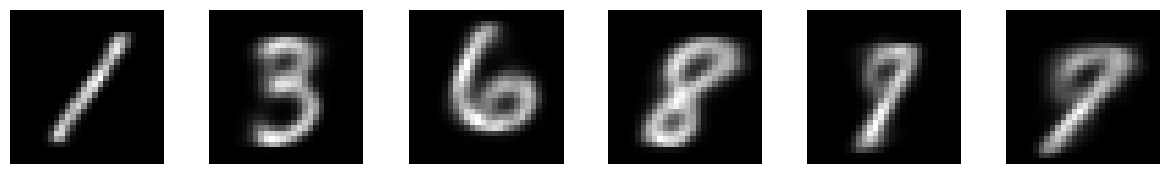


##################################################
VAE-MLP Epoch [9/10], Loss: 560.6639146158855
Sample Images:


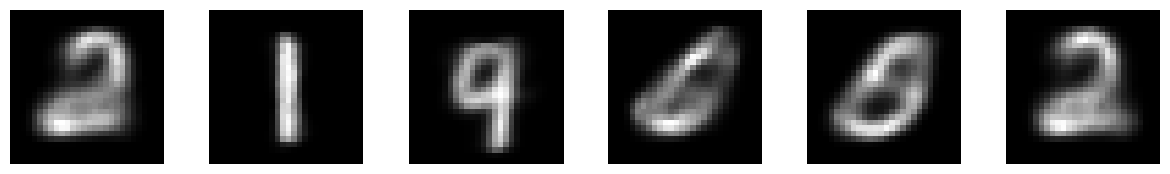


##################################################
VAE-MLP Epoch [10/10], Loss: 561.7419901367188
Sample Images:


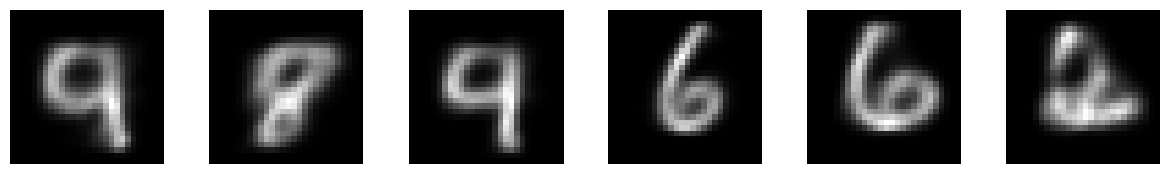

Best model saved as 'best_vae_mlp_model.pth'


In [ ]:
# Train VAE-MLP
vae_mlp = VAE_MLP(input_dim=784, hidden_dim=256, latent_dim=2)
train_vae_mlp(vae_mlp, train_loader)

# 2) CVAE --> MLP

We defined the CVAE structure the same as VAE to be more analysable; Except for the concatenate label in input.

In [ ]:
# Define a simple CVAE class with MLP architecture

class CVAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_classes):
        super(CVAE_MLP, self).__init__()
        # TODO: Define the architecture of the encoder
        self.encoder = nn.Sequential(
            # TODO: Add layers for the encoder
            nn.Linear(input_dim + num_classes, 128),
            # nn.ReLU(),
            nn.LeakyReLU(),
            nn.Linear(128, 32),
            # nn.ReLU(),
            nn.LeakyReLU(),
            nn.Linear(32, 8),
            # nn.ReLU(),
            nn.LeakyReLU(),
            # nn.Linear(8, latent_dim * 2)  # Two times latent_dim for mu and logvar
        )
        self.fc_mu = nn.Linear(8, latent_dim)
        self.fc_logvar = nn.Linear(8, latent_dim)
        self.fc_class = nn.Linear(8, num_classes)

        # TODO: Define the architecture of the decoder
        self.decoder = nn.Sequential(
            # TODO: Add layers for the decoder
            nn.Linear(latent_dim + num_classes, 8),
            # nn.LReLU(),
            nn.LeakyReLU(),
            nn.Linear(8, 32),
            # nn.ReLU(),
            nn.LeakyReLU(),
            nn.Linear(32, 128),
            # nn.ReLU(),
            nn.LeakyReLU(),
            nn.Linear(128, input_dim),
            nn.Softmax(dim=1)  # Softmax activation for multi-class classification
        )

    def reparameterize(self, mu, logvar):
        # TODO: Implement the reparameterization trick
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
        # pass

    def forward(self, x, y):
        x = x.view(x.size(0), -1)
        y = y.view(y.size(0), -1)

        # TODO: Concatenate x and y before passing them to the encoder
        x = torch.cat([x, y], dim=1)

        # TODO: Implement the forward pass
        hidden = self.encoder(x)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        z = self.reparameterize(mu, logvar)
        class_logits = self.fc_class(hidden)

        # Decoder
        zy = torch.cat([z, y], dim=1)
        reconstructed = self.decoder(zy)

        return reconstructed, mu, logvar, class_logits


In [ ]:
# Define CVAE loss function
def cvae_loss(recon, data, mu, logvar, class_logits, labels):
    # TODO: Flatten the data tensor
    data = data.view(data.size(0), -1)

    # TODO: Implement the reconstruction loss
    reconstruction_loss = F.binary_cross_entropy(recon, data, reduction='sum')

    # TODO: Implement the KL divergence loss
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # TODO: Implement the cross-entropy loss for class prediction
    ce_loss = F.cross_entropy(class_logits, labels)

    # TODO: Return the total loss as the sum of reconstruction, KL divergence, and cross-entropy losses
    return reconstruction_loss + kl_divergence + ce_loss


In [ ]:
# Training Loop - CVAE (MLP)
def train_cvae_mlp(model, train_loader, num_epochs=10, learning_rate=1e-3):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None

    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0
        for batch_idx, (data, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            # One-hot encode the labels
            labels_one_hot = F.one_hot(labels, 10)  # One-hot encode the labels

            data = data.view(data.size(0), -1)  # Flatten the images

            # TODO: Forward pass through the model and calculate the loss using cvae_loss
            recon, mu, logvar, class_logits = model(data, labels_one_hot)

            loss = cvae_loss(recon, data, mu, logvar, class_logits, labels)

            # TODO: Backpropagation and optimization step
            loss.backward()
            optimizer.step()


            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader.dataset)
        print(f'CVAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        # Show some sample images after each epoch
        if (epoch + 1) % 1 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_classes = 10  # Number of classes (0 to 9)
                num_samples_per_class = 1  # One sample per class
                # Generate random samples
                z = torch.randn(num_classes * num_samples_per_class, 2)
                # Generate one-hot encoded class labels
                y = torch.eye(num_classes).repeat(num_samples_per_class, 1)
                # Concatenate the random samples and class labels before passing them to the decoder
                sample = torch.cat([z, y], dim=1)
                sample = model.decoder(sample).view(num_classes * num_samples_per_class, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_classes, figsize=(15, 2))
                for i in range(num_classes):
                    axs[i].imshow(sample[i], cmap='gray')
                    axs[i].set_title(f"Class {i}", fontsize=16)
                    axs[i].axis('off')
                plt.show()

        # TODO: Save the best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = model.state_dict()  # TODO: Save the model

    # TODO: Save the best model to a file
    torch.save(best_model, 'best_vae_mlp_model.pth')
    print("Best model saved as 'best_cvae_mlp_model.pth'")



##################################################
CVAE-MLP Epoch [1/10], Loss: 584.5301464192709
Sample Images:


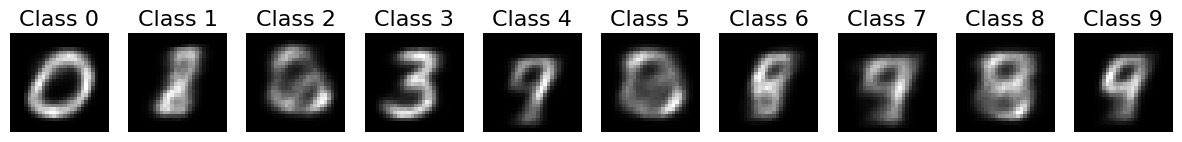


##################################################
CVAE-MLP Epoch [2/10], Loss: 564.4785748697917
Sample Images:


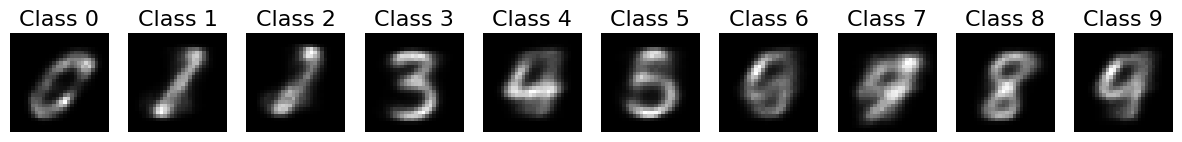


##################################################
CVAE-MLP Epoch [3/10], Loss: 558.8214091796875
Sample Images:


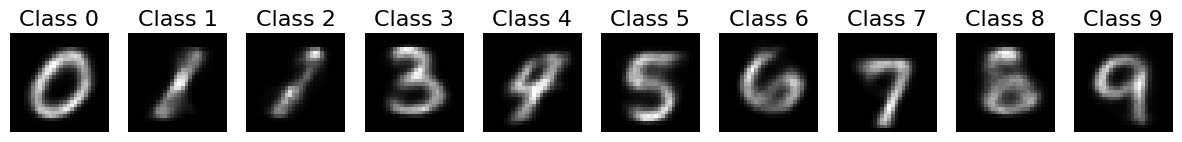


##################################################
CVAE-MLP Epoch [4/10], Loss: 556.338528938802
Sample Images:


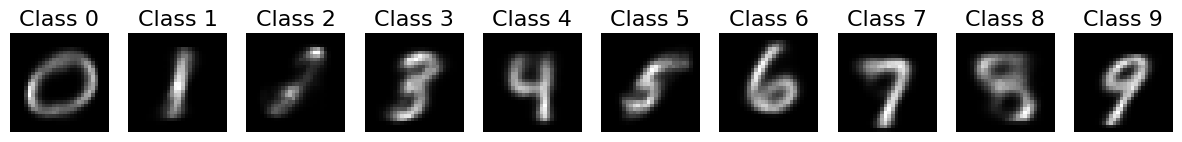


##################################################
CVAE-MLP Epoch [5/10], Loss: 554.9566722005209
Sample Images:


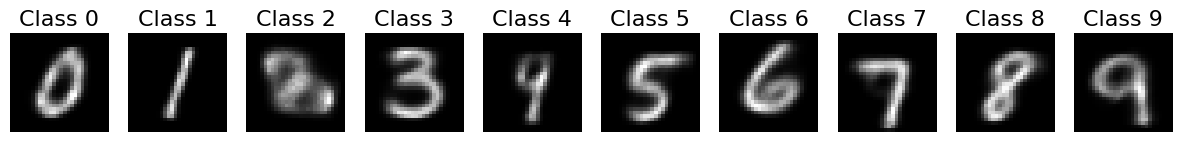


##################################################
CVAE-MLP Epoch [6/10], Loss: 554.0747942057292
Sample Images:


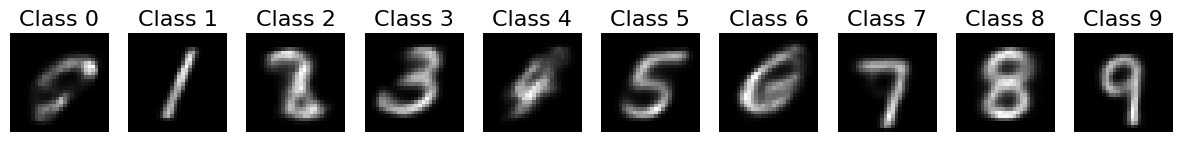


##################################################
CVAE-MLP Epoch [7/10], Loss: 553.4486784179687
Sample Images:


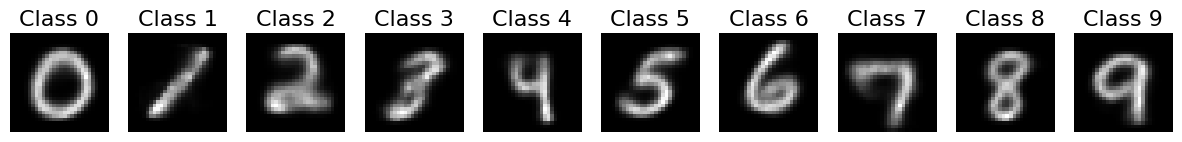


##################################################
CVAE-MLP Epoch [8/10], Loss: 552.9614680338542
Sample Images:


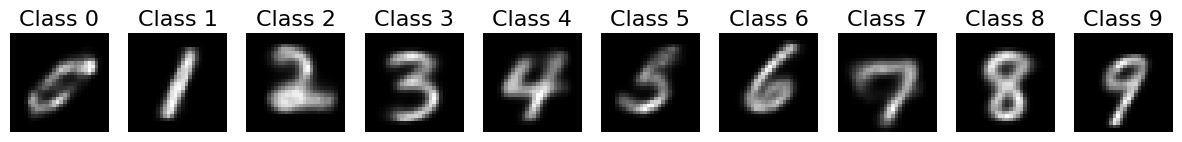


##################################################
CVAE-MLP Epoch [9/10], Loss: 552.6004234700521
Sample Images:


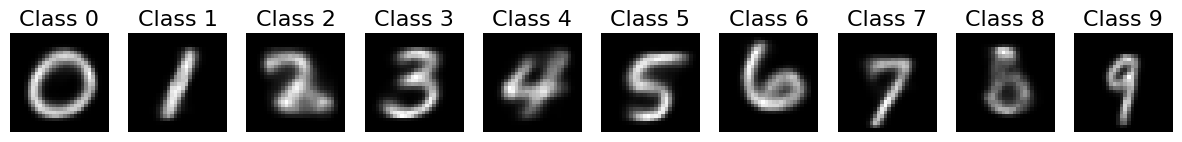


##################################################
CVAE-MLP Epoch [10/10], Loss: 552.2696550455729
Sample Images:


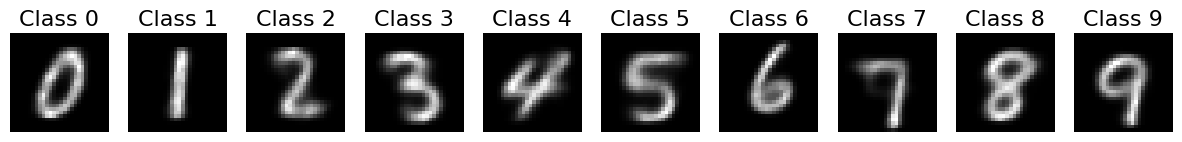

Best model saved as 'best_cvae_mlp_model.pth'


In [ ]:
cvae_mlp = CVAE_MLP(784, 256, 2, 10)
train_cvae_mlp(cvae_mlp, train_loader)

# 3) Visualizing Latent Space Distribution in Two Models

In this section, we will visualize the latent space distribution for two different models:

## Latent Space Distribution:

### VAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in VAE model.
2. Analyze the characteristics of the distribution.

### CVAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in CVAE model.
2. Analyze the characteristics of the distribution.


Summarize your findings and draw conclusions based on the observed differences in the latent space distribution between VAE (MLP) and CVAE (MLP).


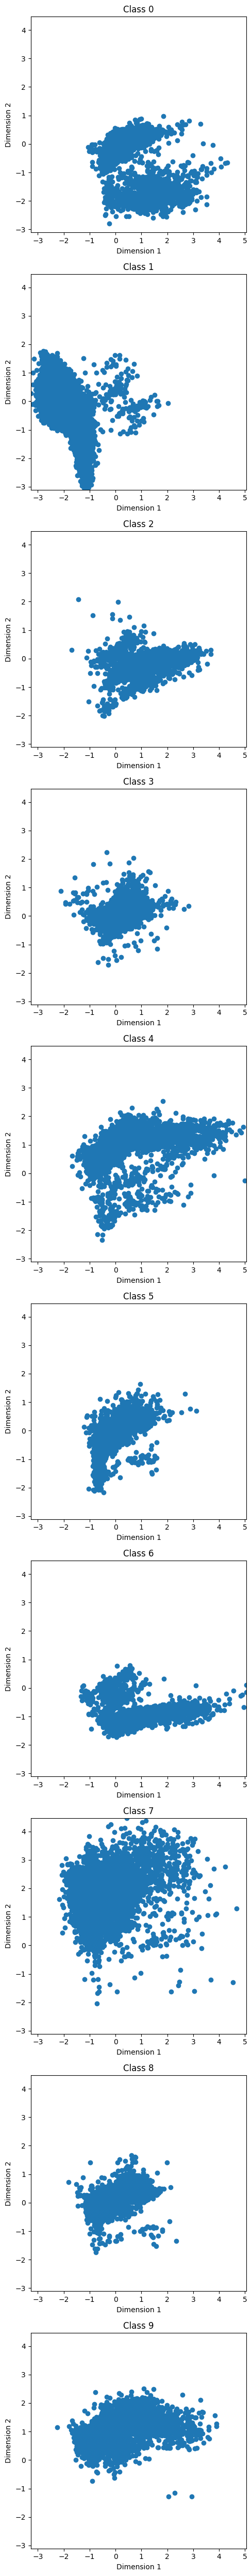

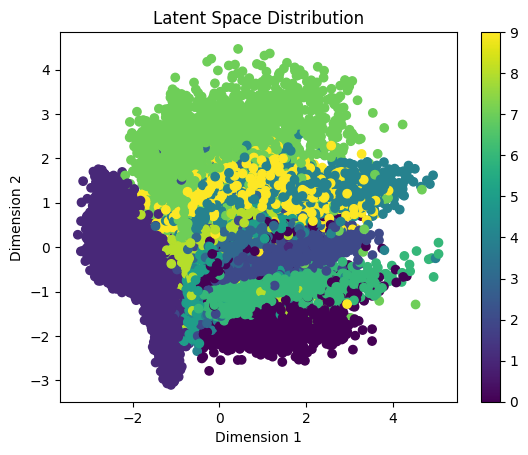

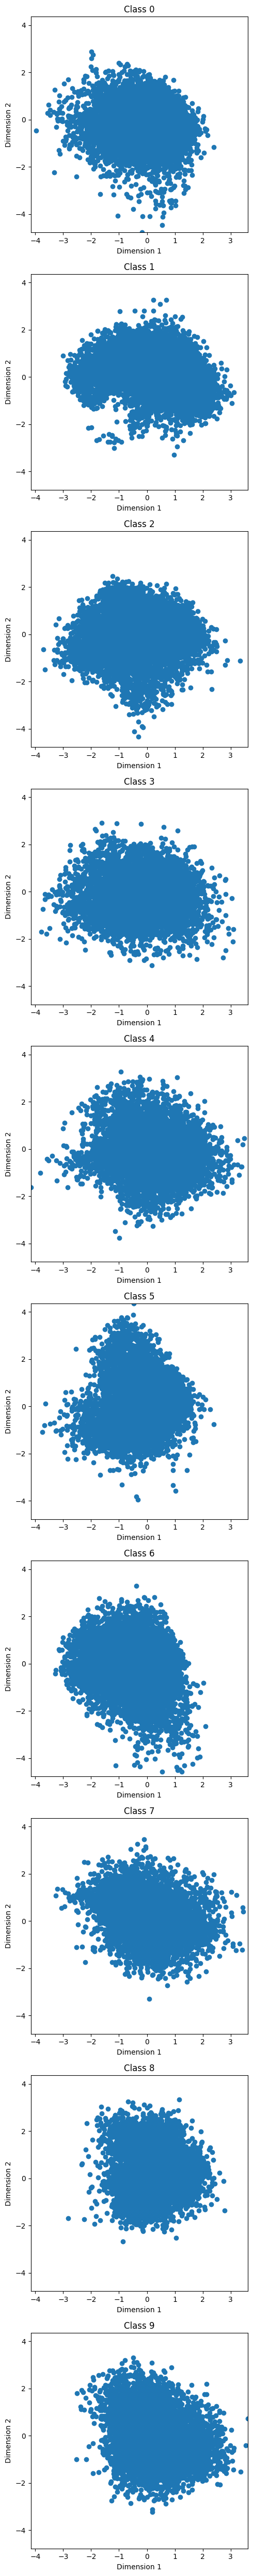

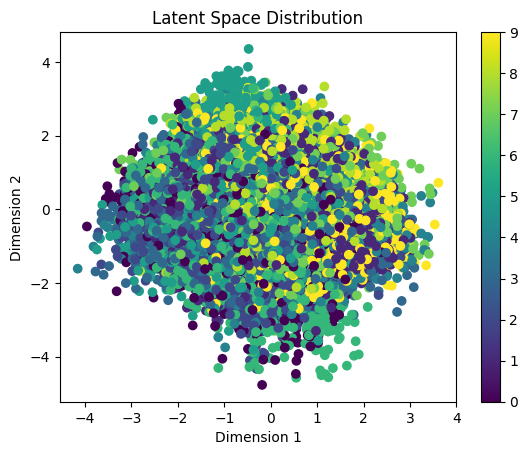

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

def visualize_latent_space(model, data_loader, model_type):
    model.eval()  # Set the model to evaluation mode
    latents, labels = [], []


    with torch.no_grad():  # No need to track gradients
        for batch_idx, (data, labelss) in enumerate(data_loader):
            data = data.view(data.size(0), -1)
            if model_type == 'VAE':
                encoded = model.encoder(data)
            elif model_type == 'CVAE':
                labels_one_hot = F.one_hot(labelss, 10)  # One-hot encode the labels
                x = data.view(data.size(0), -1)
                y = labels_one_hot.view(labels_one_hot.size(0), -1)
                # TODO: Concatenate x and y before passing them to the encoder
                x = torch.cat([x, y], dim=1)
                encoded = model.encoder(x)

            mu = model.fc_mu(encoded)
            logvar = model.fc_logvar(encoded)
            z = model.reparameterize(mu, logvar)

            latents.append(z.cpu().numpy())
            labels.append(labelss.cpu().numpy())

    # Convert list to numpy array
    latents = np.concatenate(latents, axis=0)
    labels = np.concatenate(labels, axis=0)

    unique_labels = np.unique(labels)
    min_x, min_y = np.min(latents, axis=0)
    max_x, max_y = np.max(latents, axis=0)

    num_classes = len(unique_labels)

    # Create subplots for each class
    fig, axs = plt.subplots(num_classes, 1, figsize=(5, 5 * num_classes))

    for i, label in enumerate(unique_labels):
        class_latents = latents[labels == label]

        axs[i].scatter(class_latents[:, 0], class_latents[:, 1])
        axs[i].set_title(f"Class {label}")
        axs[i].set_xlim(min_x, max_x)
        axs[i].set_ylim(min_y, max_y)
        axs[i].set_xlabel("Dimension 1")
        axs[i].set_ylabel("Dimension 2")


    plt.tight_layout()
    plt.show()


    # Plot
    plt.figure()
    plt.scatter(latents[:, 0], latents[:, 1], c=labels, cmap='viridis')
    plt.colorbar()
    plt.title("Latent Space Distribution")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()


# Visualize for VAE model
visualize_latent_space(vae_mlp, train_loader, 'VAE')
# Visualize for CVAE model
visualize_latent_space(cvae_mlp, train_loader, 'CVAE')


**CVAE:**

The distribution of points in each class seems to be relatively circular and clustered around the center. The generated images using CVAE have more resolution compared to VAE.

**VAE:**

The data points for each class seem to be more spread out and the clusters are less tight than in the CVAE plots. It seems that VAE has been forced to map each class in a different part of latent space to distinguish them. In other words, CVAE has more flexibility as a condition is applied to the network.